In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

In [2]:
import tensorflow as tf # For graphical operations

c:\users\muhammed buyukkinaci\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#DIRECTORIES
TRAIN_DIR = 'C:\\Users\\Muhammed Buyukkinaci\\python\\images\\binary_classification\\training'
TEST_DIR = 'C:\\Users\\Muhammed Buyukkinaci\\python\\images\\binary_classification\\testing'

In [4]:
# our photos are in the size of IMG_SIZE,IMG_SIZE,3
IMG_SIZE = 80

In [5]:
#Current working directory
import os, sys
print(os.getcwd()) # current working directory

C:\Users\Muhammed Buyukkinaci\python\images\binary_classification


In [6]:
#Labeling data
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == 'glass': return [1,0]
    elif word_label == 'table': return [0,1]

In [7]:
#Function for importing data from train directory.
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = TRAIN_DIR + '\\' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data_bi.npy', training_data)
    return training_data

In [8]:
#If you already have the loaded data use: test_data = train_data = np.load('train_data_bi.npy'), otherwise use train_data = create_train_data()
#train_data = create_train_data()
train_data = np.load('train_data_bi.npy')

In [9]:
#Function for importing data from test directory
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = TEST_DIR + '\\' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), label])
        
    shuffle(testing_data)
    np.save('test_data_bi.npy', testing_data)
    return testing_data

In [10]:
#If you already have the loaded data use: test_data = np.load('test_data_bi.npy'), otherwise otherwise use train_data = create_train_data()
#test_data = process_test_data()
test_data = np.load('test_data_bi.npy')

In [11]:
#For plotting
import matplotlib.pyplot as plt

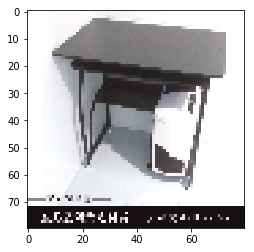

In [12]:
#A table figure
plt.imshow(np.array(test_data[190][0]))

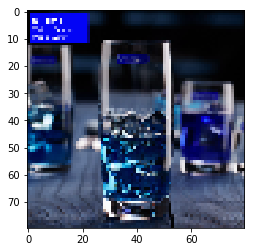

In [13]:
#A glass figure
plt.imshow(np.array(train_data[100][0]))

In [14]:
train = train_data[:5600]
cv = train_data[5600:]

In [15]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
cv_y = np.array([i[1] for i in cv])

In [16]:
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = np.array([i[1] for i in test_data])

In [17]:
X.shape

(5600, 80, 80, 3)

In [18]:
Y.shape

(5600, 2)

In [19]:
cv_x.shape

(800, 80, 80, 3)

In [20]:
test_x.shape

(1243, 80, 80, 3)

# HYPERPARAMETERS

In [21]:
lr = 0.00001
steps = 5600
epochs = 2
step_size = 32
total_batch = int(steps/step_size)

In [22]:
#STARTING WEIGHTS
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [23]:
#Starting BIAS
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [24]:
#Function for convolution operation
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [25]:
#Function for pooling layer
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [26]:
#Function for convolution layer
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [27]:
#Function for FC layer
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [28]:
X[5].shape

(80, 80, 3)

# GRAPH

In [51]:
#Resetting graph
tf.reset_default_graph()

In [52]:
#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,80,80,3])
y_true = tf.placeholder(tf.float32,shape=[None,2])

In [53]:
#Architecture for CNN
with tf.name_scope('Model'):
    #Convolutional Layer 1 + RELU
    convo_1 = convolutional_layer(x,shape=[6,6,3,32])
    #Pooling Layer 1
    convo_1_pooling = max_pool_2by2(convo_1)
    #Convolutional Layer 2 + RELU
    convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
    #Pooling Layer 2
    convo_2_pooling = max_pool_2by2(convo_2)
    #Convolutional Layer 3 + RELU
    convo_3 = convolutional_layer(convo_2_pooling,shape=[6,6,64,64])
    #Pooling Layer 3
    convo_3_pooling = max_pool_2by2(convo_3)
    #Convolutional Layer 4 + RELU
    convo_4 = convolutional_layer(convo_3_pooling,shape=[6,6,64,128])
    #Pooling Layer 4
    convo_4_pooling = max_pool_2by2(convo_4)
    #Flattening
    convo_4_flat = tf.reshape(convo_4_pooling,[-1,5*5*128])
    #Fully Connected 1 + RELU
    full_layer_one = tf.nn.relu(normal_full_layer(convo_4_flat,2048))
    #Dropout Layer 1
    hold_prob1 = tf.placeholder(tf.float32)
    full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob1)
    #Fully Connected 1 + RELU
    full_layer_two = tf.nn.relu(normal_full_layer(full_one_dropout,1024))
    #Dropout Layer 1
    hold_prob2 = tf.placeholder(tf.float32)
    full_two_dropout = tf.nn.dropout(full_layer_two,keep_prob=hold_prob2)
    #Output Layer,containing 2 output nodes.
    y_pred = normal_full_layer(full_two_dropout,2)

In [54]:
#Defining loss function
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [55]:
#Defining objective
with tf.name_scope('ADAM'):
    train = tf.train.AdamOptimizer(learning_rate=lr).minimize(cross_entropy)

In [56]:
#Defining Accuracy
with tf.name_scope('Accuracy'):
    matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [57]:
#Initializing weights
init = tf.global_variables_initializer()

In [58]:
#Tensorboard
tf.summary.scalar("loss", cross_entropy)
tf.summary.scalar("accuracy", acc)
merged_summary_op = tf.summary.merge_all()

In [59]:
#Starting Empty lists to keep results
acc_list = []
cross_entropy_list = []

In [60]:
saver = tf.train.Saver()

In [61]:
%%time
#If you are using CPU, make comment the 3 lines below.
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
with tf.Session(config=config) as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(TRAIN_DIR, graph=tf.get_default_graph())
    for i in range(epochs):
        for j in range(0,steps,step_size):
            #Feeding step_size-amount data with 0.8 keeping probabilities on DROPOUT LAYERS
            _ , c , summary,d = sess.run([train,cross_entropy,merged_summary_op,acc],feed_dict={x:X[j:j+step_size] , y_true:Y[j:j+step_size] ,hold_prob1:0.8,hold_prob2:0.8})
            summary_writer.add_summary(summary, i * total_batch + j)
            #Calculating CV loss and CV accuracy
            mean_of_cross_entropy = sess.run(cross_entropy,feed_dict={x:cv_x,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0})
            #mean_of_ll = np.mean([sess.run(cross_entropy,feed_dict={x:cv_x[:400],y_true:cv_y[:400] ,hold_prob1:1.0,hold_prob2:1.0}),sess.run(cross_entropy,feed_dict={x:cv_x[400:800],y_true:cv_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0})])
            mean_of_acc = sess.run(acc,feed_dict={x:cv_x ,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0})
            #Appending loss and accuracy
            cross_entropy_list.append(mean_of_cross_entropy)
            acc_list.append(mean_of_acc)
        print(i,mean_of_cross_entropy,mean_of_acc)
    #Saving the model
    saver.save(sess, os.getcwd()+"\\CNN_BI.ckpt")
    #Printing test accuracy and cross entropy loss on test data.
    print("test accuracy = ",np.mean([sess.run(acc,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0}),sess.run(acc,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0}),sess.run(acc,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0})]))   
    print("cross_entropy loss = ",np.mean([sess.run(cross_entropy,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0})]))   

0 3798.556 0.8125
1 2358.1296 0.84125
test accuracy =  0.81996614
cross_entropy loss =  2954.0833
Wall time: 5min 12s


In [62]:
import pandas as pd

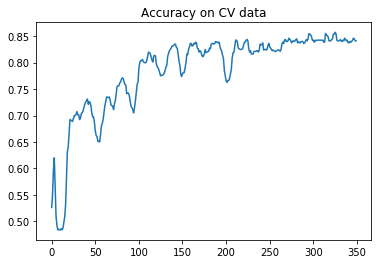

In [63]:
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data')

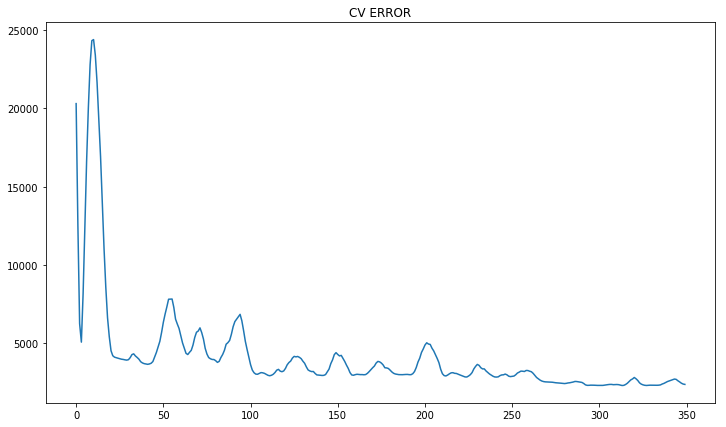

In [64]:
pd.Series(cross_entropy_list).plot(kind='line',figsize=(12,7),title='CV ERROR')

In [66]:
with tf.Session() as session:
    saver.restore(session, "CNN_BI.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([y_pred], feed_dict={x:test_x[0:64] , hold_prob1:1,hold_prob2:1})

INFO:tensorflow:Restoring parameters from CNN_BI.ckpt
Model restored.
Initialized


In [67]:
np.array(k).shape

(1, 64, 2)

In [69]:
#Reshaping k
k = np.array(k).reshape(64,2)

In [70]:
k[0]

array([-21973.018, -16228.311], dtype=float32)

In [71]:
pred_labels = []

In [72]:
for i in range(64):
    r = np.round(np.array(np.exp(k[i])/sum(np.exp(k[i]))),3).argmax()
    if r ==0 : pred_labels.append("glass")
    elif r ==1: pred_labels.append("table")

c:\users\muhammed buyukkinaci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\muhammed buyukkinaci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [73]:
#Multiple images parameters
w=80
h=80
columns = 8
rows = 8

In [74]:
images = test_x[:64]

In [75]:
images.shape

(64, 80, 80, 3)

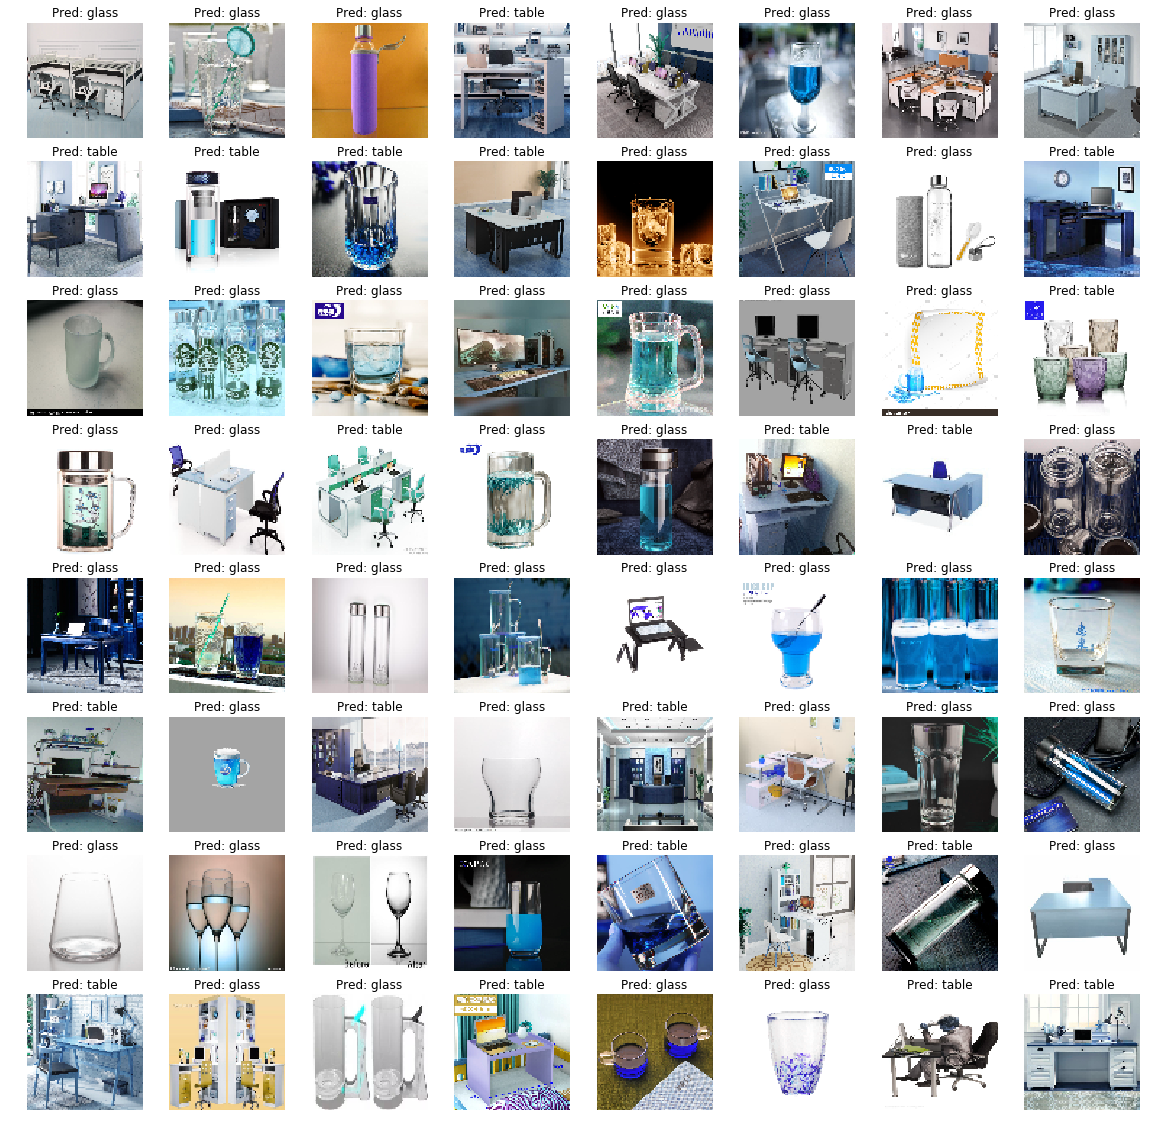

In [76]:
fig = plt.figure(figsize=(20, 20))
for m in range(1, columns*rows +1):
    img = images[m-1].reshape([80, 80, 3])
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Pred: " + pred_labels[m-1])
    plt.axis('off')
plt.show()